In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from matplotlib import pyplot as plt
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import random
from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16


In [2]:
image_path="/kaggle/input/watersegmentation2/data/images"
label_path="/kaggle/input/watersegmentation2/data/labels"

In [3]:
images = os.listdir(image_path)
print("Number of images = ", len(images))

Number of images =  306


In [4]:
images.sort(key = lambda images : int(images.split(".")[0]))

In [5]:
labels = os.listdir(label_path)
print("Number of labels = ", len(labels))

Number of labels =  456


In [6]:
modified_labels = [label for label in labels if "_" not in label.split(".")[0]]


In [7]:
modified_labels.sort(key = lambda images : int(images.split(".")[0]))


In [8]:
def load_image(img_path, size=(128, 128)):
    try:
        # Open the image file using PIL
        img = Image.open(img_path)
        img = img.convert("RGB")  # Convert to RGB if necessary
        img = img.resize(size)    # Resize the image
        img = np.array(img)       # Convert the image to a numpy array
        img = img / 255.0         # Normalize pixel values
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        img = np.zeros((*size, 3))  # Return a placeholder image if there's an error
    return img

In [9]:
def load_data(images, labels, size=(128, 128)):
    x_data = np.array([load_image(f"{image_path}/{img}") for img in images])
    y_data = np.array([load_image(f"{label_path}/{label}") for label in labels])
    return x_data, y_data

In [10]:
x_data, y_data = load_data(images, modified_labels)


Error loading image /kaggle/input/watersegmentation2/data/images/0.tif: cannot identify image file '/kaggle/input/watersegmentation2/data/images/0.tif'
Error loading image /kaggle/input/watersegmentation2/data/images/1.tif: cannot identify image file '/kaggle/input/watersegmentation2/data/images/1.tif'
Error loading image /kaggle/input/watersegmentation2/data/images/2.tif: cannot identify image file '/kaggle/input/watersegmentation2/data/images/2.tif'
Error loading image /kaggle/input/watersegmentation2/data/images/3.tif: cannot identify image file '/kaggle/input/watersegmentation2/data/images/3.tif'
Error loading image /kaggle/input/watersegmentation2/data/images/4.tif: cannot identify image file '/kaggle/input/watersegmentation2/data/images/4.tif'
Error loading image /kaggle/input/watersegmentation2/data/images/5.tif: cannot identify image file '/kaggle/input/watersegmentation2/data/images/5.tif'
Error loading image /kaggle/input/watersegmentation2/data/images/6.tif: cannot identify 

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D



In [22]:
def deeplabv3_mobilenet(input_shape=(128, 128, 3), num_classes=3):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Encoder
    x = base_model.output
    x = Conv2D(256, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    # Atrous Spatial Pyramid Pooling (ASPP) Module
    x = Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Upsample to match input size
    x = UpSampling2D(size=(32, 32), interpolation='bilinear')(x)  # Adjust size based on downsampling
    
    # Output layer: num_classes channels (RGB)
    x = Conv2D(num_classes, (1, 1), padding='same',activation='softmax')(x)  # No activation here
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

In [23]:
model = deeplabv3_mobilenet(input_shape=(128, 128, 3), num_classes=3)


In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,361,027 (16.64 MB)

 Trainable params: 4,324,867 (16.50 MB)

 Non-trainable params: 36,160 (141.25 KB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
batch_size=32

In [28]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
1/9 ━━━━━━━━━━━━━━━━━━━━ 5:56 45s/step - accuracy: 0.3637 - loss: 0.6477

I0000 00:00:1726173917.492873     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_58', 4 bytes spill stores, 4 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.3620 - loss: 0.4636 - val_accuracy: 0.0000e+00 - val_loss: 0.6222
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4087 - loss: 0.1043 - val_accuracy: 0.0000e+00 - val_loss: 0.5699
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5082 - loss: 0.0455 - val_accuracy: 0.6530 - val_loss: 0.5424
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6325 - loss: 0.0289 - val_accuracy: 0.4402 - val_loss: 0.5477
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7039 - loss: 0.0218 - val_accuracy: 0.9232 - val_loss: 0.5598
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.7015 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 0.5736
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7205 - loss: 0.0157 - val_accuracy: 0.9928 - val_loss: 0.5884


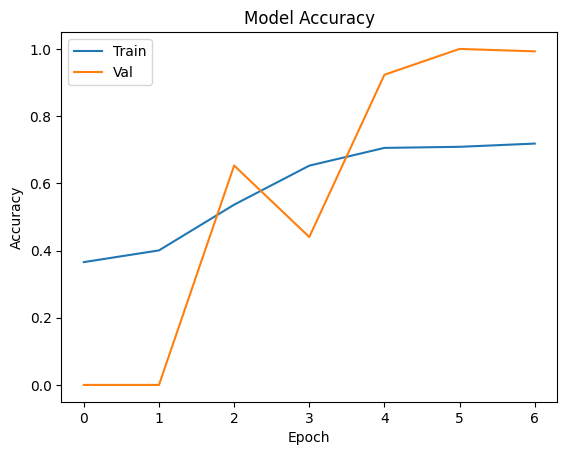

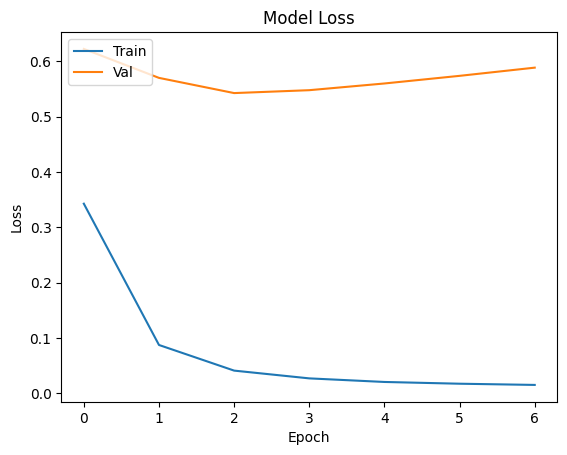

In [29]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
